# REMOVING BACKGROUND
Using Inpirednet + Rembg

## DEPENDENCIES

In [1]:
!pip install rembg -q
!pip install onnxruntime -q
!pip install python-resize-image -q
!pip install transparent-background -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.6/535.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.8 MB/s eta 0:00:00


In [2]:
import os
import io
from datetime import datetime
from rembg import remove
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from google.colab import drive
from resizeimage import resizeimage
import torch
import numpy as np
from transparent_background import Remover
from tqdm import tqdm
import cv2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## FUNCTIONS

In [5]:
# Tensor to PIL
def tensor2pil(image):
    return Image.fromarray(np.clip(255. * image.cpu().numpy().squeeze(), 0, 255).astype(np.uint8))

# Convert PIL to Tensor
def pil2tensor(image):
    return torch.from_numpy(np.array(image).astype(np.float32) / 255.0).unsqueeze(0)

class InspyrenetRembg:
    def __init__(self):
        pass

    @classmethod
    def INPUT_TYPES(s):
        return {
            "required": {
                "image": ("IMAGE",),
                "torchscript_jit": (["default", "on"],)
            },
        }

    RETURN_TYPES = ("IMAGE", "MASK")
    FUNCTION = "remove_background"
    CATEGORY = "image"

    def remove_background(self, image, torchscript_jit):
        if (torchscript_jit == "default"):
            remover = Remover()
        else:
            remover = Remover(jit=True)
        img_list = []
        for img in tqdm(image, "Inspyrenet Rembg"):
            mid = remover.process(tensor2pil(img), type='rgba')
            out =  pil2tensor(mid)
            img_list.append(out)
        img_stack = torch.cat(img_list, dim=0)
        mask = img_stack[:, :, :, 3]
        return (img_stack, mask)

class InspyrenetRembgAdvanced:
    def __init__(self):
        pass

    @classmethod
    def INPUT_TYPES(s):
        return {
            "required": {
                "image": ("IMAGE",),
                "threshold": ("FLOAT", {"default": 0.5, "min": 0.0, "max": 1.0, "step": 0.01}),
                "torchscript_jit": (["default", "on"],)
            },
        }

    RETURN_TYPES = ("IMAGE", "MASK")
    FUNCTION = "remove_background"
    CATEGORY = "image"

    def remove_background(self, image, torchscript_jit, threshold):
        if (torchscript_jit == "default"):
            remover = Remover()
        else:
            remover = Remover(jit=True)
        img_list = []
        for img in tqdm(image, "Inspyrenet Rembg"):
            mid = remover.process(tensor2pil(img), type='rgba', threshold=threshold)
            out =  pil2tensor(mid)
            img_list.append(out)
        img_stack = torch.cat(img_list, dim=0)
        mask = img_stack[:, :, :, 3]
        return (img_stack, mask)

In [6]:
def remove_background_rembg(input_image_data):
  output_image_data = remove(input_image_data, post_process_mask=True, alpha_matting=True)
  return Image.open(io.BytesIO(output_image_data))

In [7]:
model = InspyrenetRembg()
def remove_background_inspyrenet(input_image_data):
  image = pil2tensor(input_image_data)
  img_stack, mask = model.remove_background(image, torchscript_jit="default")
  output_image = tensor2pil(img_stack.squeeze())  # Convertir el tensor de vuelta a PIL
  return output_image

In [8]:
def pil_to_cv2(image):
  image = np.array(image)
  return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

## IMPLEMENTATION

In [9]:
input_folder = '/content/drive/My Drive/ALOHA/REMOVE_BG/INPUT/'
output_folder_base = '/content/drive/My Drive/ALOHA/REMOVE_BG/OUTPUT/'
watermark_path = '/content/drive/My Drive/ALOHA/REMOVE_BG/watermark.png'  # Ruta de la marca de agua

current_date = datetime.now().strftime('%d-%m-%y')
output_folder = os.path.join(output_folder_base, current_date)
os.makedirs(output_folder, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/transparent_background/Remover.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted b

Settings -> Mode=base, Device=cpu, Torchscript=disabled


Inspyrenet Rembg: 100%|██████████| 1/1 [01:04<00:00, 64.80s/it]


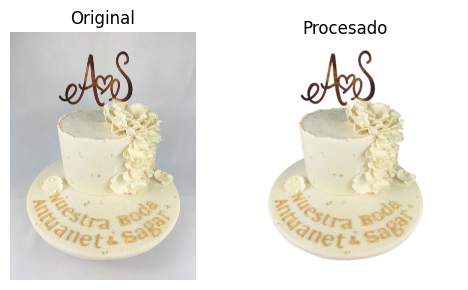

Settings -> Mode=base, Device=cpu, Torchscript=disabled


Inspyrenet Rembg: 100%|██████████| 1/1 [00:56<00:00, 56.75s/it]


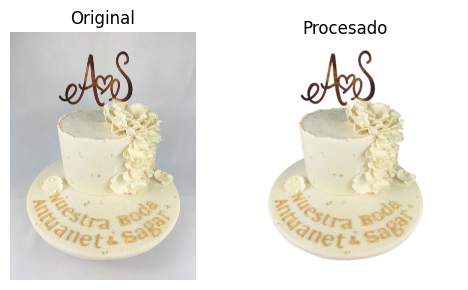

Settings -> Mode=base, Device=cpu, Torchscript=disabled


Inspyrenet Rembg: 100%|██████████| 1/1 [00:54<00:00, 54.37s/it]


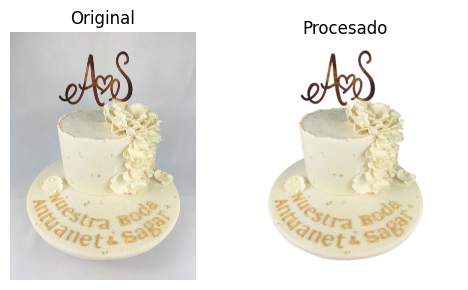

Settings -> Mode=base, Device=cpu, Torchscript=disabled


Inspyrenet Rembg:   0%|          | 0/1 [00:38<?, ?it/s]


KeyboardInterrupt: 

In [10]:
for filename in os.listdir(input_folder):
  if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
    # input_path = os.path.join(input_folder, filename)
    input_path = os.path.join(input_folder, "PXL_20240808_120523658.MP.jpg")
    output_path = os.path.join(output_folder, filename)

    # Leer la imagen original
    with open(input_path, "rb") as input_file:
      input_image_data = input_file.read()

    # Convertir los bytes a imágenes PIL
    input_image = Image.open(io.BytesIO(input_image_data))

    # Remover el fondo
    # output_image = remove_background_rembg(input_image_data)
    output_image = remove_background_inspyrenet(input_image)

    # Convertir a RGB si es necesario
    if output_image.mode != 'RGBA':
      output_image = output_image.convert('RGBA')

    # Recortar la parte de la imagen que tiene contenido (sin transparencia)
    bbox = output_image.getbbox()
    if bbox:
      output_image = output_image.crop(bbox)

    # Enhance
    # gray_image = cv2.cvtColor(pil_to_cv2(output_image), cv2.COLOR_RGB2GRAY)
    # equalized_image = cv2.equalizeHist(gray_image)
    # output_image = Image.fromarray(equalized_image)

    # Aplicar brillo y contraste
    # brightness_enhancer = ImageEnhance.Brightness(output_image)
    # output_image = brightness_enhancer.enhance(1.07)

    # contrast_enhancer = ImageEnhance.Contrast(output_image)
    # output_image = contrast_enhancer.enhance(1.1)

    # Crear un fondo blanco de 900x900
    canvas_size = 900
    margin = 35
    background = Image.new('RGBA', (canvas_size, canvas_size), (255, 255, 255, 0))

    # Calcular el tamaño máximo permitido para la imagen procesada
    max_size = canvas_size - 2 * margin
    output_image = resizeimage.resize_contain(output_image, [max_size, max_size])

    # Centrar la imagen en el fondo blanco
    offset = ((canvas_size - output_image.width) // 2, (canvas_size - output_image.height) // 2)
    background.paste(output_image, offset, output_image)

    # Eliminar el canal alfa para asegurar el fondo blanco
    background = background.convert('RGB')

    # Guardar la imagen procesada con fondo blanco
    output_path = os.path.splitext(output_path)[0] + ".png"
    background.save(output_path, format='PNG')

    # Mostrar el antes y después lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))
    axes[0].imshow(input_image)
    axes[0].axis('off')
    axes[0].set_title('Original')

    axes[1].imshow(background)
    axes[1].axis('off')
    axes[1].set_title('Procesado')

    plt.tight_layout()
    plt.show()
    # break;

print(f"Procesamiento completado. Imágenes procesadas guardadas en: {output_folder}")